# **Datasets that were used for this project**

All datasets have been taken from Kaggle.com and are free to use by anyone.

> The first dataset is Fruits 360: https://www.kaggle.com/moltean/fruits

> The second dataset that is used is Waste dataset: https://www.kaggle.com/szdxfkmgnb/waste-classification

> The third dataset that is used is called Garbage Classification (12 classes) dataset: https://www.kaggle.com/mostafaabla/garbage-classification?fbclid=IwAR06p8i1Ct4-XUPC8WiYsPozvibMeHAmuHZ5iW3Zi3BVtWvLNmEk-rzBjnA







# **Google Colab and Kaggle Union**
It is not necessary to unite Google Colab and Kaggle, but I am uniting it for the fact that downloading the datasets and uploading them in the Google Colab is going to be much faster than in Google Drive.

> https://www.kaggle.com/general/74235





In [ ]:
! pip install -q kaggle

In [ ]:
 from google.colab import files 
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"evaldasvainaviius","key":"8d0d9c77b4504ac688383a7b9f21d27f"}'}

In [ ]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d evaldasvainaviius/final-year-one-dataset
! unzip final-year-one-dataset

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
#Importing the necessary libraries for the code

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

# Printing all file names that exist in fruits-360 folder
# In addition, getting all the subfolders from Training folder (which will be all the classes of fruits)

#data_dir = '/content/Dataset(Wastes)'
data_dir = '/content/fruits-360'
print('Folders :', os.listdir(data_dir))
print("******************************************************************************")
classes = os.listdir(data_dir + "/Training")
print('There are: ' + str(len(classes)) + ' classes. ', classes)

Folders : ['Training', 'readme.md', 'Test', 'test-multiple_fruits', 'LICENSE']
******************************************************************************
There are: 140 classes.  ['Dates', 'Pepper Yellow', 'Tomato Yellow', 'Grapefruit Pink', 'Grape Blue', 'Papaya', 'Nut Pecan', 'Pear Stone', 'Passion Fruit', 'Cocos', 'Cherry Rainier', 'Redcurrant', 'Cucumber Ripe', 'Quince', 'Tamarillo', 'Nectarine', 'Apple Red 1', 'Apple Braeburn', 'Raspberry', 'Fig', 'Ginger Root', 'Corn', 'Mango Red', 'Potato Sweet', 'Corn Husk', 'Pear Abate', 'Carambula', 'Nut Forest', 'Tomato 2', 'Avocado', 'Lychee', 'Nectarine Flat', 'Clementine', 'Banana', 'Pepino', 'Physalis with Husk', 'Cantaloupe 2', 'Grape White 3', 'Pear Monster', 'Apple Golden 1', 'Tomato 4', 'Mulberry', 'Potato White', 'cardboard', 'Orange', 'Mangostan', 'Cherry Wax Yellow', 'Cherry Wax Black', 'Tomato Cherry Red', 'Plum 2', 'plastic', 'Tomato Heart', 'Potato Red Washed', 'Cantaloupe 1', 'Pear', 'Apple Red 3', 'metal', 'Blueberry', 'g

In [ ]:
#Getting the total amount of images in Training folder and in Test folder

transforming = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])

dataset = ImageFolder(data_dir + '/Training', transform=transforming)
print('Size of training dataset :', len(dataset))
test = ImageFolder(data_dir + '/Test', transform=transforming)
print('Size of test dataset :', len(test))

Size of training dataset : 80731
Size of test dataset : 30179


In [ ]:
# view one image shape of the dataset.
img, label = dataset[599]
print(img.shape)
print(label)

torch.Size([3, 100, 100])
1


Label:  Apple Crimson Snow (1)


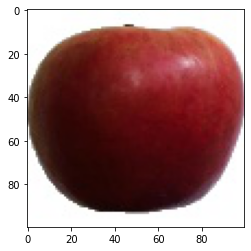

In [ ]:
# function for showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_image(*dataset[599])

# **Google Colab and GPU usage**

Google Colab allows each free user to use its own installed GPU for everyone. It also has a very powerful CPU, but when there is a need to complete heavy tasks using GPU is much more efficient. Therefore, for the sake of this project GPU will be used to complete each task, where possible.

The following code below, checks if the Google Colab's GPU is allowed and if the program can access it. If it can, then we switch the application runtime to use GPU instead of CPU.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()
device

device(type='cuda')

# **Preparing data for training, validation and testing**

Data preparation is taking place in this section. The data is splitted into three parts: Training, Validation and Testing.

In [ ]:
torch.manual_seed(20) #Torch manual seed is acting like a saving point, with the provided number the output of the program is always going to be the same
val_size = len(dataset)//10 #Validation data size is determined by 
train_size = len(dataset) - val_size
print(val_size)

8073


In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds) # train_ds length = dataset length - val_ds length

(72658, 8073)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_ds,
                          batch_size,
                          shuffle= True, 
                          num_workers=4, 
                          pin_memory=True)

val_loader = DataLoader(val_ds,
                        batch_size*2,
                        num_workers=4,
                        pin_memory=True)

test_loader = DataLoader(test,
                         batch_size*2,
                         num_workers=4,
                         pin_memory=True)

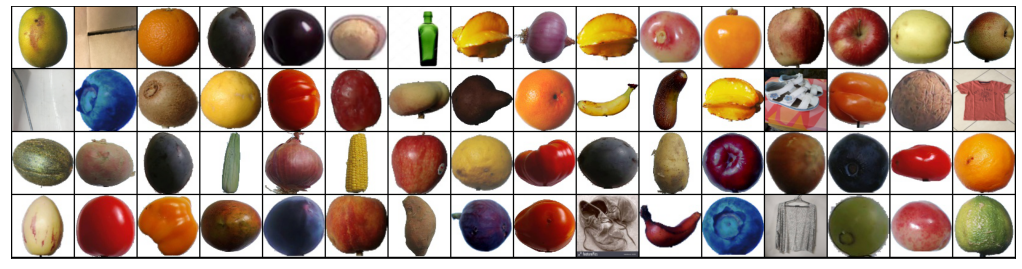

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
input_size = 3*100*100
output_size = len(classes)

# **Logistic Regression Model**

The following code below shows the use of Logistic Regression model in Pytorch with the given dataset.

In [ ]:
# Logistic regression model
model = nn.Linear(input_size, output_size)

In [ ]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([ 89,  31, 127,  44, 134, 139, 116,  85, 109,  44,  74,  76,  70, 135,
         94, 110, 134, 115,  36,  21,   7,  96,   8,  49,  92,  21,  11,  72,
         12,   0, 138, 115, 138,  82, 117,  14,  65,  10, 124, 119,  98, 136,
         23,  81, 130,   9,  12, 139,  58,  41,  63,  21,  20,  77,  86,  17,
         63,  35, 138,  33, 139,   3,  98, 138])
torch.Size([64, 3, 100, 100])


RuntimeError: ignored

In [ ]:
images.shape

torch.Size([64, 3, 100, 100])

In [ ]:
images.reshape(batch_size, 30000).shape

torch.Size([64, 30000])

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
loss_fn = F.cross_entropy

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 30000)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()


In [ ]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.005967027507722378, 'val_loss': 5.034130096435547}

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.005967027507722378, 'val_loss': 5.034130096435547}]

In [ ]:
history = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.7003, val_acc: 0.4136
Epoch [1], val_loss: 2.0335, val_acc: 0.5819
Epoch [2], val_loss: 1.6670, val_acc: 0.6819
Epoch [3], val_loss: 1.4290, val_acc: 0.7398
Epoch [4], val_loss: 1.2595, val_acc: 0.7648


In [ ]:
history = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1495, val_acc: 0.7798
Epoch [1], val_loss: 1.0887, val_acc: 0.7779
Epoch [2], val_loss: 0.9820, val_acc: 0.8151
Epoch [3], val_loss: 0.9345, val_acc: 0.8217
Epoch [4], val_loss: 0.8695, val_acc: 0.8370


In [ ]:
history = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8258, val_acc: 0.8475
Epoch [1], val_loss: 0.7854, val_acc: 0.8509
Epoch [2], val_loss: 0.7765, val_acc: 0.8480
Epoch [3], val_loss: 0.7598, val_acc: 0.8401
Epoch [4], val_loss: 0.7038, val_acc: 0.8683


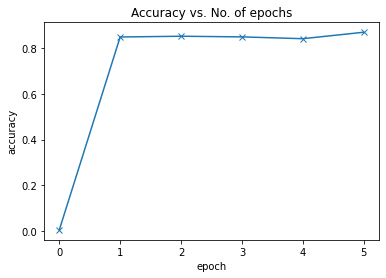

In [ ]:
history = [result0] + history
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 12 , Predicted: 12


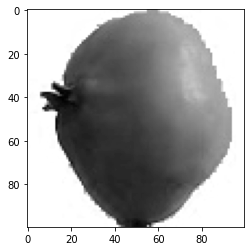

In [ ]:
img, label = test[2000]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DataLoader(dataset, batch_size=256)
result = evaluate(model, test_loader)
result

# **FeedForward Neural Network (FNN)**

In [ ]:
#The Base step is the same in every algorithm, it will always include training_step, validation_step, validation_epoch_end
#and epoch_end! The code will always look the same for every algorithm in its base case! No changes should be made unless
#there is a need, but most of the times there is no need to do that!
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
#This is also the base of all algorithms, the same as the one above with ImageClassificationBase! 
#It should only be modified if necessary, but in most cases it is not!

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*100*100
output_size = len(classes)

In [ ]:
class ModelFNN(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [ ]:
model = to_device(ModelFNN(input_size, output_size), device)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.005474901758134365, 'val_loss': 4.941228866577148}]

In [ ]:
history += fit(7, 0.01, model, train_loader, val_loader)


Epoch [0], train_loss: 4.1855, val_loss: 3.8929, val_acc: 0.0625



Epoch [1], train_loss: 2.4741, val_loss: 2.6317, val_acc: 0.3117



Epoch [2], train_loss: 1.4390, val_loss: 1.2271, val_acc: 0.6301



Epoch [3], train_loss: 0.9513, val_loss: 0.7297, val_acc: 0.7780



Epoch [4], train_loss: 0.7176, val_loss: 0.8032, val_acc: 0.7792



Epoch [5], train_loss: 0.5830, val_loss: 0.8266, val_acc: 0.7493



Epoch [6], train_loss: 0.4891, val_loss: 0.6123, val_acc: 0.7921


In [ ]:
history += fit(8, 0.001, model, train_loader, val_loader)


Epoch [0], train_loss: 0.3120, val_loss: 0.3074, val_acc: 0.9109



Epoch [1], train_loss: 0.2895, val_loss: 0.2969, val_acc: 0.9128



Epoch [2], train_loss: 0.2806, val_loss: 0.2908, val_acc: 0.9124



Epoch [3], train_loss: 0.2747, val_loss: 0.2849, val_acc: 0.9157



Epoch [4], train_loss: 0.2703, val_loss: 0.2799, val_acc: 0.9163



Epoch [5], train_loss: 0.2658, val_loss: 0.2813, val_acc: 0.9158



Epoch [6], train_loss: 0.2621, val_loss: 0.2743, val_acc: 0.9169



Epoch [7], train_loss: 0.2587, val_loss: 0.2703, val_acc: 0.9201


In [ ]:
history += fit(3, 0.001, model, train_loader, val_loader)


Epoch [0], train_loss: 0.2560, val_loss: 0.2687, val_acc: 0.9193



Epoch [1], train_loss: 0.2532, val_loss: 0.2640, val_acc: 0.9210



Epoch [2], train_loss: 0.2506, val_loss: 0.2688, val_acc: 0.9182


In [ ]:
evaluate(model, test_loader)

# **Convolutional Neural Network (CNN)**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(), 
            nn.Linear(36000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(500, output_size))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = CnnModel()
model.cuda()

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36000, out_features=1000, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36000, out_features=1000, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(CnnModel(), device)

In [ ]:
history=[evaluate(model, val_loader)]
history

[{'val_acc': 0.0067138671875, 'val_loss': 4.942709445953369}]

In [ ]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.2788, val_loss: 0.5484, val_acc: 0.8308



Epoch [1], train_loss: 0.2747, val_loss: 0.2085, val_acc: 0.9266



Epoch [2], train_loss: 0.2092, val_loss: 0.2410, val_acc: 0.9233



Epoch [3], train_loss: 0.1821, val_loss: 0.2047, val_acc: 0.9328



Epoch [4], train_loss: 0.1434, val_loss: 0.2294, val_acc: 0.9280



Epoch [5], train_loss: 0.1213, val_loss: 0.2283, val_acc: 0.9350



Epoch [6], train_loss: 0.0959, val_loss: 0.2674, val_acc: 0.9365



Epoch [7], train_loss: 0.0731, val_loss: 0.2949, val_acc: 0.9366


In [ ]:
history += fit(num_epochs, lr/10, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.0290, val_loss: 0.3377, val_acc: 0.9406



Epoch [1], train_loss: 0.0186, val_loss: 0.4000, val_acc: 0.9431



Epoch [2], train_loss: 0.0139, val_loss: 0.4327, val_acc: 0.9449



Epoch [3], train_loss: 0.0116, val_loss: 0.4717, val_acc: 0.9438



Epoch [4], train_loss: 0.0095, val_loss: 0.5203, val_acc: 0.9427



Epoch [5], train_loss: 0.0081, val_loss: 0.5808, val_acc: 0.9428



Epoch [6], train_loss: 0.0064, val_loss: 0.6153, val_acc: 0.9425



Epoch [7], train_loss: 0.0057, val_loss: 0.6595, val_acc: 0.9428


In [ ]:
evaluate(model, test_loader)

{'val_acc': 0.8400363326072693, 'val_loss': 2.2205848693847656}

In [ ]:
def predict_image(img, label):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, pred = torch.max(yb, dim = 1)
  return dataset.classes[preds[0].item()]

In [ ]:
img, label = test[0]
plt.imshow(img.permute(1,2,0))
print ('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))